<a href="https://colab.research.google.com/github/neurorishika/PSST/blob/master/Tutorial/Day%204%20Neurons%20and%20Networks/Day%204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neurorishika/PSST/master/Tutorial/Day%204%20Neurons%20and%20Networks/Day%204.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

## Day 4: Neurons and Networks

Welcome to Day 4! In this section we simulate a network of neurons interacting via synapses. 

### How do we model Synapses?

Each synapse is defined by its own set of state variables and differential equations governing their temporal evolution. There are different kinds of synapses - electrical and chemical synapses. Electrical synapses are essentially physical conduits that allow the flow of ions across connected neurons. Chemical synapses are more common in the brain and are more complex than electrical synapses. When an action potential arrives at the axon terminal, it leads to the opening of voltage-gated calcium channels. The incoming calcium triggers neurotransmitter filled vesicles to fuse with the axon terminal membrane and release their cargo into the synaptic cleft. The neurotransmitters diffuse across the cleft and open (or close) ion channels on the post-synaptic neuron. This can cause a depolarization (increase in potential across the post-synaptic neuron's membrane) that makes it easier for the neuron to spike or it can inhibit the neuron and have the opposite effect. In some cases these effects are fast and direct - a neurotransmitter binds to a receptor in the post-synaptic site that causes an influx or efflux of ions and leads to a change in the membrane potential. The effect of a synapse can also be indirect such that neurotransmitters invoke a second messenger cascade that eventually leads to the opening or closing of ion channels in the post-synaptic neuron. 

Here we model fast excitatory and inhibitory chemical synapses that utilize the neurotransmitter Acetylcholine (Ach) and  γ-Aminobutyric Acid (GABA) respectively (Steratt, 2011). The network of interactions between neurons will be described by a connectivity matrix. Different connectivity matrices describe the interactions due to different types of synapses. 

#### Modelling Synapses


The synaptic current ($I_{syn}$) depends on the difference between the reversal potential ($E_{syn}$) and the value of the membrane potential ($u$). The synaptic current due to neurotransmitter release into the synaptic cleft following an action potential is given by,
$$I_{syn}(t)=g_{syn}(t)(u(t)−E_{syn})$$

When the transmitter binds to postsynaptic receptors it causes a transient change in the conductance $g_{syn}$. To capture the dynamics of $g_{syn}$, one models the system using a simple kinetic model where the receptors can be either in an open or a closed state (Destexhe, 1994). The transition between the states is proportional to the concentration of the neurotransmitter $[T]$ in the cleft. 
$$ \mathrm{C}\underset{\beta}{\stackrel{\alpha[T]}{\rightleftharpoons}} \mathrm{O} $$

This may be rewritten in the form of a differential equation.
$$\frac{d[O]}{dt}=\alpha[T](1−[O])−\beta[O]$$

We can now describe the synaptic conductance $g_{syn}(t)=g_{max}[O]$, in terms of the maximal conductance $g_{max}$ and a gating variable $[O]$, where $[O](t)$ is the fraction of open synaptic channels. $\alpha$ is the binding constant, $\beta$ the unbinding constant and $(1−[O])$ the fraction of closed channels where the neurotransmitter can bind. The functional form of T depends on the nature of the synapse.

For cholinergic excitatory synapses, $[T]$ is given by,

$$[T]_{ach} = A\ \Theta(t_{max}+t_{fire}+t_{delay}-t)\ \Theta(t-t_{fire}-t_{delay})$$

where, $\Theta (x)$ is the Heaviside step function, $t_{fire}$ is the time of the last presynaptic spike, $t_{delay}$ is the time delay from the time of the last spike to its effect on the postsynaptic neuron and $t_{max}$ is the duration after the spike during which the transmitter remains in the synaptic cleft.
For Fast GABAergic inhibitory synapses, we used the following equation,

$$[T]_{gaba} = \frac{1}{1+e^{-\frac{V(t-t_{fire}-t_{delay})-V_0}{\sigma}}}$$

Note that in order to solve this equation, we need to determine the time when the presynaptic neuron fired ($t_{fire}$). To account for these synaptic interactions between neurons we need to modify the RK4 integrator developed to simulate multiple independent Hodgkin-Huxley neurons. 

#### Iterating over conditionals in TensorFlow


In this section we modify the integrator that we coded on Day 2 to account for interactions between neurons. This will require an additional variable that stores the time elapsed from the last presynaptic spike to calculate the  equations. In the modified code we will use the TensorFlow function $\texttt{tf.where()}$ to efficiently assign the indices of neurons that have spiked and those that have not spiked at each time point. To understand the usage and function of $\texttt{tf.where()}$, consider the following example. Say, you have a array $\texttt{x}$ of 10 random numbers between 0 and 1. You want the output of the code to be another array of the same size as $\texttt{x}$ such that the elements of the array are either -10 or 10 depending on whether the corresponding element in $\texttt{x}$ is less or greater than 0.5. The function  $\texttt{tf.where(cond,a,b)}$ outputs an array with elements from $\texttt{a}$ if the condition $\texttt{cond}$ is $\texttt{True}$ and from $\texttt{b}$ if $\texttt{cond}$ is $\texttt{False}$. See the example code below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

# create the Tensor with the random variables
x = tf.constant(np.random.uniform(size = (10,)),dtype=tf.float64)

# a list of 10s to select from if true
if_true = tf.constant(10*np.ones((10,)),dtype=tf.float64)

# a list of -10s to select from if false
if_false = tf.constant(-10*np.ones((10,)),dtype=tf.float64)

# perform the conditional masking
selection = tf.where(tf.greater(x,0.5),if_true,if_false)

with tf.Session() as sess:
    x_out = sess.run(x)
    selection_out = sess.run(selection)

print(x_out)
print(selection_out)

[0.67409821 0.45097017 0.70497614 0.82002797 0.94004653 0.88966049
 0.33526257 0.16079188 0.8861437  0.13353322]
[ 10. -10.  10.  10.  10.  10. -10. -10.  10. -10.]


#### Redesigning the Generalized TensorFlow Integrator
In order to determine whether a particular neuron fired, we introduce a new variable fire\_t that stores the time of the last spike for each neuron. 

We modify the code as follows:
1. The Integrator class that we defined earlier now requires two more properties as input, namely, the number of neurons ($n$) and the firing threshold ($F_b$) of each of these neurons. We provide these inputs as arguments to the Integrator class.
2. The state vector will now have an additional set of $n$ variables representing the firing times. These will not be updated by the step function ($\_step\_func$).
3. Inside the Integrator class, we have access to the values of the state variable and the change in the state variable since the last iteration. We use this to check if the voltages have crossed the firing threshold. The convention followed in this code is, the first $n$ elements of the state vector are the membrane voltages while the last $n$ elements are the time from the last spike for each of the neurons.
4. The differential update function, $step\_func$, takes all except the last $n$ values of the state variable and updates it according to the differential equations specified in $func$. The last $n$ variables are updated separately in $scan\_func$. It checks if any neuron has crossed its firing threshold and updates the variable $fire\_t$ of the appropriate neurons with the current time.

The modifications to the RK4 code implemented earlier is shown below,

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

%matplotlib inline


def tf_check_type(t, y0): # Ensure Input is Correct
    """
    This function checks the type of the input to ensure that it is a floating point number.
    """
    if not (y0.dtype.is_floating and t.dtype.is_floating):
        raise TypeError('Error: y0 and t must be floating point numbers.')

class _Tf_Integrator():
    """
    This class implements the Runge-Kutta 4th order method in TensorFlow with last Spike Time Calculation.
    """
    def __init__(self,n_,F_b): 
        """
        This function initializes the class with the number of neurons and the firing threshold.

        Parameters
        ----------
        n_ : int
            Number of neurons in the system.
        F_b : list or np.array of floats
            Firing threshold of the neurons.
        """
        # class constructor to get inputs for number of neurons and firing thresholds
        self.n_ = n_
        self.F_b = F_b
    
    def integrate(self, func, y0, t):
        """
        This function integrates a function func using the Runge-Kutta 4th order method in TensorFlow with last Spike Time Calculation.

        Parameters:
        -----------
        func: function
            The function to be integrated.
        y0: float
            The initial condition.
        t: numpy array
            The time array.
        """
        time_delta_grid = t[1:] - t[:-1] # define the time step at each point
        
        def scan_func(y, t_dt):
            """
            This function performs the integration step and last spike time calculation.
            
            Parameters:
            -----------
            y: float
                The value of y at which the function is being evaluated.
            t_dt: (float, float)
                The time point and time step at which the function is being evaluated.
            """
            # recall the necessary variables
            n_ = self.n_ # number of neurons
            F_b = self.F_b # firing threshold
            
            t, dt = t_dt # unpack the time point and time step
            
            # Differential updation
            dy = self._step_func(func,t,dt,y) # Make code more modular.
            dy = tf.cast(dy, dtype=y.dtype) # Failsafe
           
            out = y + dy # the result after differential updation
        
            # Conditional to use specialized Integrator vs Normal Integrator (n=0)
            if n_>0:
                
                # Extract the last n variables for fire times
                fire_t = y[-n_:] 
                
                # Value of change in firing times if neuron didnt fire = 0
                l = tf.zeros(tf.shape(fire_t),dtype=fire_t.dtype) 
                
                # Value of change in firing times if neuron fired = Current Time - Last Fire Time
                l_ = t-fire_t 
                
                # Check if Voltage is initially less than Firing Threshold
                z = tf.less(y[:n_],F_b)              
                # Check if Voltage is more than Firing Threshold after updation
                z_ = tf.greater_equal(out[:n_],F_b)  
                
                df = tf.where(tf.logical_and(z,z_),l_,l) 
                
                fire_t_ = fire_t+df # Update firing time 
                
                return tf.concat([out[:-n_],fire_t_],0) # Remove and Update the last n variables with new last spike times
            else:
                return out
            
        y = tf.scan(scan_func, (t[:-1], time_delta_grid),y0) # Perform the integration
        
        return tf.concat([[y0], y], axis=0) # Add the initial condition to the result and return
    
    def _step_func(self, func, t, dt, y):
        """
        This function determines the size of the step.

        Parameters:
        -----------
        func: function
            The function to be integrated.
        t: float
            The time point at which the function is being evaluated.
        dt: float
            The time step at which the function is being integrated.
        y: float
            The value of y at which the function is being evaluated.
        """
        k1 = func(y, t)
        half_step = t + dt / 2
        dt_cast = tf.cast(dt, y.dtype) # Failsafe

        k2 = func(y + dt_cast * k1 / 2, half_step)
        k3 = func(y + dt_cast * k2 / 2, half_step)
        k4 = func(y + dt_cast * k3, t + dt)
        return tf.add_n([k1, 2 * k2, 2 * k3, k4]) * (dt_cast / 6)
    

def odeint(func, y0, t, n_, F_b):
    """
    This function integrates the function func using the modified Runge-Kutta 4th order method implemented in the _Tf_Integrator class

    Parameters:
    -----------
    func: function
        The function to be integrated.
    y0: float
        The initial condition.
    t: numpy array
        The time array.
    n_: int
        Number of neurons in the system.
    F_b: list or np.array of floats
        Firing threshold of the neurons.
    """
    # Ensure Input is in the form of TensorFlow Tensors
    t = tf.convert_to_tensor(t, preferred_dtype=tf.float64, name='t')
    y0 = tf.convert_to_tensor(y0, name='y0')
    tf_check_type(y0,t) # Ensure Input is of the correct type
    return _Tf_Integrator(n_, F_b).integrate(func,y0,t)

#### Implementing a network of Hodgkin-Huxley Neurons

Recall, each Hodgkin Huxley Neuron in a network with $n$ neurons has 4 dynamical variables $V$, $ m$, $n$, $h$. Each of these variables were represented as $n$-dimensional vectors. Now we need to add some more state variables representing each synapse. The neuron receives excitatory and inhibitory inputs that are introduced as additional synaptic currents $I_{ach}$ and $I_{GABA}$. The equation now reads, 

$$C_m\frac{dV}{dt} = I_{injected} - I_{Na} - I_K - I_L - I_{ach} - I_{gaba}$$

For each synapse, we have:

$$\frac{d[O]_{ach/gaba}}{dt} = \alpha (1-[O]_{ach/gaba})[T]_{ach/gaba}-\beta[O]_{ach/gaba}$$

$$I_{ach/gaba}(t)=g_{max}[O]_{ach/gaba}(V−E_{ach/gaba})$$

#### Synaptic Memory Management

As discussed earlier, there are atmost $n^2$ synapses of each type but at a time, unless the network is fully connected/very dense, mostly we need a very small subset of these synapses. We could, in principle, calculate the dynamics of all $n^2$ but it would be pointless. So have to devise a matrix based sparse-dense coding system for evaluating the dynamics of these variables and also using their values. This will reduce memory usage and minimize number of calculations at the cost of time for encoding and decoding into dense data from sparse data and vice versa. This is why we use a matrix approach, so that tensorflow can speed up the process. 

#### Defining the Connectivity

In a network with n neurons, there are at most $n^2$ synapses of each type. The actual number may be much smaller. To illustrate the details of the implementation, consider the following three neuron network. Let $X_1$ be an excitatory neuron that forms a cholinergic synapse, $X_2$ an inhibitory neuron that extends a GABAergic synapse onto $X_3$. The network has the form: $X_1 \rightarrow X_2 \rightarrow X_3$. In defining the connectivity matrix for each synapse type, we set a convention where the presynaptic neurons are indexed by the column number, and the postsynaptic neurons by the row number. Let $X_1$, $X_2$, $X_3$ be indexed as 0, 1 and 2 respectively. The excitatory connectivity matrix takes the form

$$Ach_{n\times n}=
\begin{bmatrix}
0&0&0\\
1&0&0\\
0&0&0\\
\end{bmatrix}
$$

Similarly, the inhibitory connectivity matrix becomes:

$$GABA_{n\times n}=
\begin{bmatrix}
0&0&0\\
0&0&0\\
0&1&0\\
\end{bmatrix}
$$

In the following code we specify the parameters of the synapse. The number of synapses of each type are determined by adding up all the elements of the connectivity matrix. Other parameters are specified as vectors with values for each of the synapses.

In [3]:
n_n = 3                             # number of simultaneous neurons to simulate

# Acetylcholine

ach_mat = np.zeros((n_n,n_n))       # Ach Synapse Connectivity Matrix
ach_mat[1,0]=1

## PARAMETERS FOR ACETYLCHLOLINE SYNAPSES ##

n_ach = int(np.sum(ach_mat))        # Number of Acetylcholine (Ach) Synapses 
alp_ach = [10.0]*n_ach              # Alpha for Ach Synapse
bet_ach = [0.2]*n_ach               # Beta for Ach Synapse
t_max = 0.3                         # Maximum Time for Synapse
t_delay = 0                         # Axonal Transmission Delay
A = [0.5]*n_n                       # Synaptic Response Strength
g_ach = [0.35]*n_n                  # Ach Conductance
E_ach = [0.0]*n_n                   # Ach Potential

# GABAa

gaba_mat = np.zeros((n_n,n_n))      # GABAa Synapse Connectivity Matrix
gaba_mat[2,1] = 1

## PARAMETERS FOR GABAa SYNAPSES ##

n_gaba = int(np.sum(gaba_mat))      # Number of GABAa Synapses
alp_gaba = [10.0]*n_gaba            # Alpha for GABAa Synapse
bet_gaba = [0.16]*n_gaba            # Beta for GABAa Synapse
V0 = [-20.0]*n_n                    # Decay Potential
sigma = [1.5]*n_n                   # Decay Time Constant
g_gaba = [0.8]*n_n                  # fGABA Conductance
E_gaba = [-70.0]*n_n                # fGABA Potential


#### Defining Firing Thresholds

We shall also define a list that stores the firing threshold for every neuron.

In [4]:
## Storing Firing Thresholds ##
F_b = [0.0]*n_n                      # Fire threshold

#### Defining Input Current as function of Time

We can store our input to each neuron as a $n\times timesteps$ matrix, say current_input, and extract the input at each time point during dynamical update step using a function which we shall call I_inj_t(t).

In [5]:
def I_inj_t(t):
    """
    This function returns the external current to be injected into the network at any time step from the current_input matrix.

    Parameters:
    -----------
    t: float
        The time at which the current injection is being performed.
    """
    # Turn indices to integer and extract from matrix
    index = tf.cast(t/epsilon,tf.int32)
    return tf.constant(current_input.T,dtype=tf.float64)[index] 

#### Defining the connectivity matrix and calculating currents

For updating the dynamics of synapses, we need only as many variables as the number of synapses $\times$ number of equations required for each synapse. Here our synapse models require only one dynamical variable, the fraction of open channels $[O]$, that we store as an $k$—dimensional vector, where $k$ is the number of synapses. There are two instances where the $[O]$ vector is used. First, to solve the equation for $[o]$ and second, to calculate the synaptic current given by, 

$$I_{syn} = \sum_{presynaptic} g_{syn}[O](V-E_{syn})$$

The best way to represent this calculation is to use the connectivity matrix $\mathbf{C}$ for the synapses and the open fraction vector $\vec{[O]}$ to create an open fraction matrix $\mathbf{O}$ and perform the following computations.

$$\mathbf{C}=
\begin{bmatrix}
0&1&...&0\\
0&0&...&1\\
...&...&...&1\\
1&0&0&0
\end{bmatrix}\ \ \ \ \ \ \ \ \vec{[O]}=[O_1,O_2...O_k]\ \ \ \ \ \ \ \ 
\mathbf{O}=
\begin{bmatrix}
0&O_1&...&0\\
0&0&...&O_a\\
...&...&...&O_b\\
O_k&0&0&0
\end{bmatrix}
$$

$$\vec{[I_{syn}]}=\sum_{columns}\mathbf{O}\diamond(\vec{g}_{syn}\odot(\vec{V}-\vec{E}_{syn}))$$

where $\diamond$ is columnwise multiplication and $\odot$ is elementwise multiplication. $\vec{[I_{syn}]}$ is now the total synaptic current input to the each of the neurons.

##### Steps to calculate the Synaptic Currents

1. Firstly we need to convert from the sparse $[O]$ vector to the dense $\mathbf{O}$ matrix. TensorFlow does not allow to make changes to a defined tensor directly, thus we create a $n^{2}$ vector TensorFlow variable o\_ which we will later reshape to a $n\times n$ matrix.
2. We then flatten the synaptic connectivity matrix and find the indices where there is a connection. For this we use the boolean mask function to choose the correct k (total number of synapses) indices from the range $1$ to $n^2$ and store in the variable ind.
3. Using the scatter\_update function of TensorFlow, we fill the correct indices of the variable o\_ that we created with the values of open fraction from the $[O]$ vector.
4. We now reshape the vector as a $n\times n$ matrix. Since python stores matrices as array of arrays, with each row as an inner array, for performing columnswise multiplication, the easiest way is to tranpose the matrix, so that each column is the inner array, perform element wise multiplication with each inner array and apply transpose again.
5. Finally using reduce\_sum, we sum over the columns to get our $I_{syn}$ vector.

In [6]:
## Acetylcholine Synaptic Current ##

def I_ach(o,V):
    """
    This function returns the synaptic current for the Acetylcholine (Ach) synapses for each neuron.

    Parameters:
    -----------
    o: float
        The fraction of open acetylcholine channels for each synapse.
    V: float
        The membrane potential of the postsynaptic neuron.
    """
    o_ = tf.constant([0.0]*n_n**2,dtype=tf.float64) # Initialize the flattened matrix to store the synaptic open fractions
    ind = tf.boolean_mask(tf.range(n_n**2),ach_mat.reshape(-1) == 1) # Get the indices of the synapses that exist
    o_ = tf.tensor_scatter_nd_update(o_,tf.reshape(ind,[-1,1]),o) # Update the flattened open fraction matrix
    o_ = tf.transpose(tf.reshape(o_,(n_n,n_n))) # Reshape and Transpose the matrix to be able to multiply it with the conductance matrix
    return tf.reduce_sum(tf.transpose((o_*(V-E_ach))*g_ach),1) # Calculate the synaptic current

## GABAa Synaptic Current ##

def I_gaba(o,V):
    """
    This function returns the synaptic current for the GABA synapses for each neuron.

    Parameters:
    -----------
    o: float
        The fraction of open GABA channels for each synapse.
    V: float
        The membrane potential of the postsynaptic neuron.
    """
    o_ = tf.constant([0.0]*n_n**2,dtype=tf.float64) # Initialize the flattened matrix to store the synaptic open fractions
    ind = tf.boolean_mask(tf.range(n_n**2),gaba_mat.reshape(-1) == 1) # Get the indices of the synapses that exist
    o_ = tf.tensor_scatter_nd_update(o_,tf.reshape(ind,[-1,1]),o) # Update the flattened open fraction matrix
    o_ = tf.transpose(tf.reshape(o_,(n_n,n_n))) # Reshape and Transpose the matrix to be able to multiply it with the conductance matrix
    return tf.reduce_sum(tf.transpose((o_*(V-E_gaba))*g_gaba),1) # Calculate the synaptic current

# For TensorFlow v2.x, use tf.tensor_scatter_nd_update instead of 
# tf.scatter_update and make o_ a tf.constant instead of a tf.variable
# Also ind must be reshaped to be a column matrix.

## Other Currents ##

def I_K(V, n):
    """
    This function determines the K-channel current.

    Parameters:
    -----------
    V: float
        The membrane potential.
    n: float 
        The K-channel gating variable n.
    """
    return g_K  * n**4 * (V - E_K)

def I_Na(V, m, h):
    """
    This function determines the Na-channel current.
    
    Parameters:
    -----------
    V: float
        The membrane potential.
    m: float
        The Na-channel gating variable m.
    h: float
        The Na-channel gating variable h.
    """
    return g_Na * m**3 * h * (V - E_Na)

def I_L(V):
    """
    This function determines the leak current.

    Parameters:
    -----------
    V: float
        The membrane potential.
    """
    return g_L * (V - E_L)

#### Updating Synaptic Variables

To update the synapses we first calculate the values of the presynaptic activation function $[T]$ for both types of synapses. This function determines whether a neuron fired or not and is calculated for each neuron. The values of $[T]$ are then sent to the correct synapses in the form of a $k \times 1$ vector. Recall:

$$[T]_{ach} = A\ \Theta(t_{max}+t_{fire}+t_{delay}-t)\ \Theta(t-t_{fire}-t_{delay})$$

$$[T]_{gaba} = \frac{1}{1+e^{-\frac{V(t)-V_0}{\sigma}}}$$

Once we calculate the values of $[T]$-vector for both types of synapse, we need to redirect them to the correct synapses in a sparse $k \times 1$ vector form.

##### Steps to calculate [T]

1. To calculate $[T]_{ach}$, use a boolean logical_and function to check is the current timepoint t is greater than the last fire time (fire\_t) + delay (t\_delay) and less than last fire time (fire\_t) + delay (t\_delay) + activation length (t\_max) for each neuron as a vector. Use the result of these boolean operations to choose between zero or an constant A. This serves as the heaviside step function. For $[T]_{gaba}$, simply use the V vector to determine T.
2. To determine the [T] vector, we follow as two step process. First we multiply each row of the connectivity matrices $\mathbf{C}$ with the respective $[T]$ vector to get a activation matrix $\mathbf{T}$, and then we just flatten $\mathbf{T}$ and $\mathbf{C}$ and, using tf.boolean\_mask, remove all the zeros from $\mathbf{T}$ to get a $k\times1$ vector which now stores the presynaptic activation for each of the synapses where $k=n_{gaba}$ or $n_{ach}$
3. Calculate the differential change in the open fractions using the $k\times1$ vector.


In [7]:
def dXdt(X, t):
    """
    This function determines the derivatives of the membrane voltage and gating variables for n_n neurons.

    Parameters:
    -----------
    X: float
        The state vector given by the [V1,V2,...,Vn_n,m1,m2,...,mn_n,h1,h2,...,hn_n,n1,n2,...,nn_n] where 
            Vx is the membrane potential for neuron x
            mx is the Na-channel gating variable for neuron x 
            hx is the Na-channel gating variable for neuron x
            nx is the K-channel gating variable for neuron x.
    t: float
        The time points at which the derivatives are being evaluated.
    """
    V = X[:1*n_n]       # First n_n values are Membrane Voltage
    m = X[1*n_n:2*n_n]  # Next n_n values are Sodium Activation Gating Variables
    h = X[2*n_n:3*n_n]  # Next n_n values are Sodium Inactivation Gating Variables
    n = X[3*n_n:4*n_n]  # Next n_n values are Potassium Gating Variables
    o_ach = X[4*n_n : 4*n_n + n_ach] # Next n_ach values are Acetylcholine Synapse Open Fractions
    o_gaba = X[4*n_n + n_ach : 4*n_n + n_ach + n_gaba] # Next n_gaba values are GABAa Synapse Open Fractions
    fire_t = X[-n_n:]   # Last n_n values are the last fire times as updated by the modified integrator
    
    dVdt = (I_inj_t(t) - I_Na(V, m, h) - I_K(V, n) - I_L(V) - I_ach(o_ach,V) - I_gaba(o_gaba,V)) / C_m # The derivative of the membrane potential
    
    ## Updation for gating variables ##
    
    m0,tm,h0,th = Na_prop(V) # Calculate the dynamics of the Na-channel gating variables for all n_n neurons
    n0,tn = K_prop(V) # Calculate the dynamics of the K-channel gating variables for all n_n neurons

    dmdt = - (1.0/tm)*(m-m0) # The derivative of the Na-channel gating variable m for all n_n neurons
    dhdt = - (1.0/th)*(h-h0) # The derivative of the Na-channel gating variable h for all n_n neurons
    dndt = - (1.0/tn)*(n-n0) # The derivative of the K-channel gating variable n for all n_n neurons
    
    ## Updation for o_ach ##
    
    A_ = tf.constant(A,dtype=tf.float64) # Get the synaptic response strengths of the pre-synaptic neurons
    Z_ = tf.zeros(tf.shape(A_),dtype=tf.float64) # Create a zero matrix of the same size as A_
    
    T_ach = tf.where(tf.logical_and(tf.greater(t,fire_t+t_delay),tf.less(t,fire_t+t_max+t_delay)),A_,Z_)  # Find which synapses would have received an presynaptic spike in the past window and assign them the corresponding synaptic response strength
    T_ach = tf.multiply(tf.constant(ach_mat,dtype=tf.float64),T_ach) # Find the postsynaptic neurons that would have received an presynaptic spike in the past window
    T_ach = tf.boolean_mask(tf.reshape(T_ach,(-1,)),ach_mat.reshape(-1) == 1) # Get the pre-synaptic activation function for only the existing synapses
    
    do_achdt = alp_ach*(1.0-o_ach)*T_ach - bet_ach*o_ach  # Calculate the derivative of the open fraction of the acetylcholine synapses
     
    ## Updation for o_gaba ##
          
    T_gaba = 1.0/(1.0+tf.exp(-(V-V0)/sigma)) # Calculate the presynaptic activation function for all n_n neurons
    T_gaba = tf.multiply(tf.constant(gaba_mat,dtype=tf.float64),T_gaba) # Find the postsynaptic neurons that would have received an presynaptic spike in the past window
    T_gaba = tf.boolean_mask(tf.reshape(T_gaba,(-1,)),gaba_mat.reshape(-1) == 1) # Get the pre-synaptic activation function for only the existing synapses
    
    do_gabadt = alp_gaba*(1.0-o_gaba)*T_gaba - bet_gaba*o_gaba # Calculate the derivative of the open fraction of the GABAa synapses
    
    ## Updation for fire times ##
    
    dfdt = tf.zeros(tf.shape(fire_t),dtype=fire_t.dtype) # zero change in fire_t as it will be updated by the modified integrator
    
    out = tf.concat([dVdt,dmdt,dhdt,dndt,do_achdt,do_gabadt,dfdt],0) # Concatenate the derivatives of the membrane potential, gating variables, and open fractions
    return out


#### Updaing the Gating Variable and the Initial Conditions

As before, we again define functions that return the values of $\tau_m$, $\tau_h$, $\tau_n$, $m_0$, $h_0$, $n_0$, set parameters and initial conditions. 

Note: The last firing times are stored in the $n$ elements of the state vector. If we initialize the last firing time as 0, then the second neuron $X_2$ will get an EPSP immediately after the start of the simulation. To avoid this the last firing time should be initialized to a large negative number greater than the duration of the simulation.

In [8]:
def K_prop(V):
    """
    This function determines the K-channel gating dynamics.

    Parameters:
    -----------
    V: float
        The membrane potential.
    """
    T = 22 # Temperature
    phi = 3.0**((T-36.0)/10) # Temperature-correction factor
    V_ = V-(-50) # Voltage baseline shift
    
    alpha_n = 0.02*(15.0 - V_)/(tf.exp((15.0 - V_)/5.0) - 1.0) # Alpha for the K-channel gating variable n
    beta_n = 0.5*tf.exp((10.0 - V_)/40.0) # Beta for the K-channel gating variable n
    
    t_n = 1.0/((alpha_n+beta_n)*phi) # Time constant for the K-channel gating variable n
    n_0 = alpha_n/(alpha_n+beta_n) # Steady-state value for the K-channel gating variable n
    
    return n_0, t_n


def Na_prop(V):
    """
    This function determines the Na-channel gating dynamics.
    
    Parameters:
    -----------
    V: float
        The membrane potential.
    """
    T = 22 # Temperature 
    phi = 3.0**((T-36)/10)  # Temperature-correction factor
    V_ = V-(-50) # Voltage baseline shift
    
    alpha_m = 0.32*(13.0 - V_)/(tf.exp((13.0 - V_)/4.0) - 1.0) # Alpha for the Na-channel gating variable m
    beta_m = 0.28*(V_ - 40.0)/(tf.exp((V_ - 40.0)/5.0) - 1.0) # Beta for the Na-channel gating variable m
    
    alpha_h = 0.128*tf.exp((17.0 - V_)/18.0) # Alpha for the Na-channel gating variable h
    beta_h = 4.0/(tf.exp((40.0 - V_)/5.0) + 1.0) # Beta for the Na-channel gating variable h
    
    t_m = 1.0/((alpha_m+beta_m)*phi) # Time constant for the Na-channel gating variable m
    t_h = 1.0/((alpha_h+beta_h)*phi) # Time constant for the Na-channel gating variable h
    
    m_0 = alpha_m/(alpha_m+beta_m) # Steady-state value for the Na-channel gating variable m
    h_0 = alpha_h/(alpha_h+beta_h) # Steady-state value for the Na-channel gating variable h
    
    return m_0, t_m, h_0, t_h


# Initializing the Parameters

C_m = [1.0]*n_n         # Membrane capacitances
g_K = [10.0]*n_n        # K-channel conductances
E_K = [-95.0]*n_n       # K-channel reversal potentials

g_Na = [100]*n_n        # Na-channel conductances
E_Na = [50]*n_n         # Na-channel reversal potentials

g_L = [0.15]*n_n        # Leak conductances
E_L = [-55.0]*n_n       # Leak reversal potentials


# Initializing the State Vector

y0 = tf.constant([-71]*n_n+[0,0,0]*n_n+[0]*n_ach+[0]*n_gaba+[-9999999]*n_n,dtype=tf.float64) # Initial state vector

#### Creating the Current Input and Run the Simulation

We will run an 700 ms simulation with 100ms current injection at neuron $X_1$ of increasing amplitude with 100ms gaps in between.

*Note: The following cell can take a few minutes to run the simulation depending on your device.*

In [9]:
epsilon = 0.01 # The step size for the numerical integration
t = np.arange(0,700,epsilon) # The time points for the numerical integration

current_input= np.zeros((n_n,t.shape[0])) # The current input to the network
current_input[0,int(100/epsilon):int(200/epsilon)] = 2.5
current_input[0,int(300/epsilon):int(400/epsilon)] = 5.0
current_input[0,int(500/epsilon):int(600/epsilon)] = 7.5

state = odeint(dXdt,y0,t,n_n,F_b) # Solve the Differential Equation

with tf.Session() as sess:
    # # Since we are using variables we have to initialize them
    # tf.global_variables_initializer().run()
    state = sess.run(state)

#### Visualizing and Interpreting the Output

We overlay the voltage traces for the three neurons and observe the dynamics.

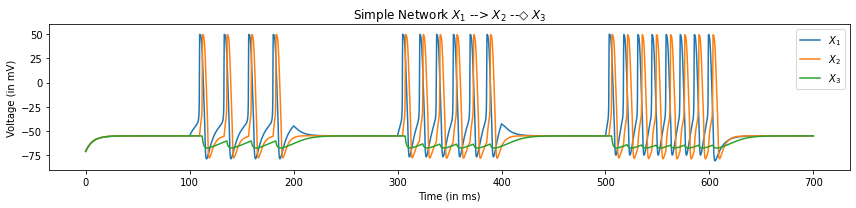

In [10]:
# Plot the membrane potentials
plt.figure(figsize=(12,3))
plt.plot(t,state[:,0],label="$X_1$")
plt.plot(t,state[:,1],label="$X_2$")
plt.plot(t,state[:,2],label="$X_3$")
plt.title("Simple Network $X_1$ --> $X_2$ --◇ $X_3$")
plt.ylim([-90,60])
plt.xlabel("Time (in ms)")
plt.ylabel("Voltage (in mV)")
plt.legend()
plt.tight_layout()
plt.show()

We can see that the current injection triggers the firing of action potentials with increasing frequency with increasing current. Also we see that as soon as the first neuron $X_1$ crosses its fireing threshold, an EPSP is triggered in the next neuron $X_2$ causing a firing with a slight delay from the firing of $X_1$. Finally, as the second neuron depolarizes, we see a corresponding hyperpolarization in the next neuron $X_3$ caused by an IPSP. We can also plot the dynamics of the channels itself by plotting $o_{Ach}$ and $o_{GABA}$ which are the 5th and 4th last elements respectively.

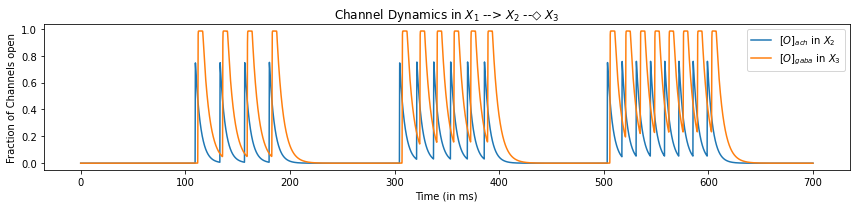

In [11]:
# Plot the fraction of open channels

plt.figure(figsize=(12,3))
plt.plot(t,state[:,-5],label="$[O]_{ach}$ in $X_2$")
plt.plot(t,state[:,-4],label="$[O]_{gaba}$ in $X_3$")
plt.title("Channel Dynamics in $X_1$ --> $X_2$ --◇ $X_3$")
plt.xlabel("Time (in ms)")
plt.ylabel("Fraction of Channels open")
plt.legend()
plt.tight_layout()
plt.show()

So, we can see that the increase in the fraction of open Acetylcholine channels ($o_{Ach}$) serves as an excitatory interaction and triggers an action potential in neuron $X_2$. On the other hand, the increase in the fraction of open GABA channels ($o_{GABA}$) serves as an inhibitory interaction and triggers the hyperpolarization of the neuron $X_3$. 

Thus we are now capable of making complex networks of neurons with both excitatory and inhibitory connections.

# References

(<a id="cit-Destexhe1994" href="#call-Destexhe1994">Destexhe, Mainen <em>et al.</em>, 1994</a>) Destexhe Alain, Mainen Zachary F. and Sejnowski Terrence J., ``_Synthesis of models for excitable membranes, synaptic transmission and neuromodulation using a common kinetic formalism_'', Journal of Computational Neuroscience, vol. 1, number 3, pp. 195--230,  1994.

(<a id="cit-Steratt2011" href="#call-Steratt2011">Sterratt, David <em>et al.</em>, 2011</a>) Sterratt, D., Graham, B., Gillies, A., & Willshaw, D. , ``_Chapter 7. Principles of Computational Modelling in Neuroscience._'', Cambridge: Cambridge University Press,  2011.
